# 17.9. 생성적 적대 신경망

## 개요

- Ian Goodfellow et al. (2014) 논문에서 제안

- 두 개의 신경망(**생성자**와 **판별자**)으로 구성

1. 생성자
- 입력 : 랜덤한 분포(가우시안 분포)
- 출력 : 생성하고자 하는 대상 (예시. 이미지)
- 랜덤한 분포(노이즈)를 주입하여 이미지를 생성함

2. 판별자
- 입력 : 생성자에서 얻은 **가짜** 이미지, 훈련 데이터셋에서 얻은 **진짜** 이미지
- 출력 : 가짜/진짜
- 입력된 이미지가 진짜인지 가짜인지 판별함

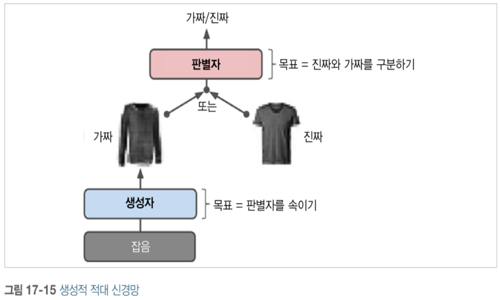

In [3]:
from PIL import Image
Image.open('./gan.PNG').resize((500, 300))

## 훈련 과정

1. 판별자 훈련
- **진짜 이미지 샘플링** : 훈련 데이터셋에서 진짜 이미지를 샘플링
- **가짜 이미지 샘플링** : 생성자에서 동일한 수의 가짜 이미지를 샘플링
- **라벨링** : 가짜 이미지(0), 진짜 이미지(1)
- **훈련** : 이진 크로스 엔트로피(binary cross entropy)를 손실함수로 적용하여 학습 => 판별자의 가중치만 최적화 됨

2. 생성자 훈련
- **가짜 이미지 샘플링** : 생성자에서 가짜 이미지를 샘플링 (판별자 훈련 과정에서 생성된 이미지와 다른 이미지)
- **라벨링** : 전부 1 (판별자가 진짜 이미지라고 판별하는지 평가하기 위해)
- **훈련** : 판별자가 구분한 결과를 기준으로 학습 (많은 가짜 이미지를 진짜 이미지라고 판별할수록 손실함수는 0에 가까워짐) => 생성자의 가중치만 최적화 됨

In [16]:
"""패션 MNIST 데이터 불러오기"""
import numpy as np
import tensorflow as tf
from tqdm import tqdm

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32)
X_test  = X_test.astype( np.float32)
print(X_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


  0%|          | 0/10 [00:00<?, ?it/s]

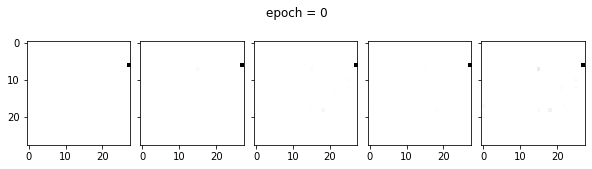

 10%|█         | 1/10 [00:30<04:34, 30.48s/it]

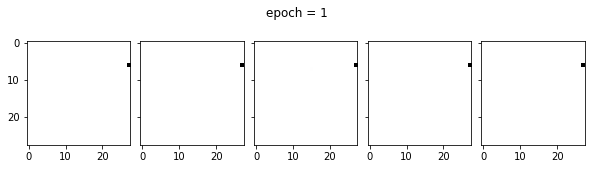

 20%|██        | 2/10 [01:00<04:03, 30.47s/it]

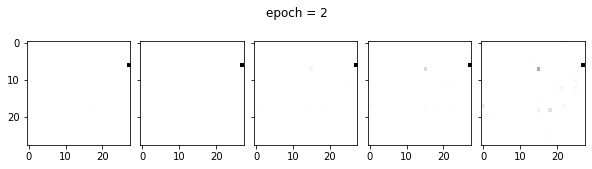

 30%|███       | 3/10 [01:32<03:35, 30.81s/it]

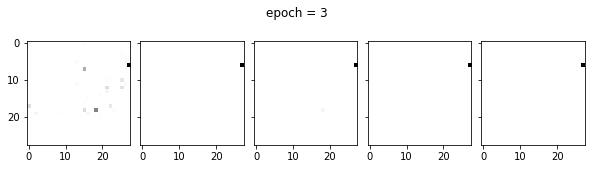

 40%|████      | 4/10 [02:03<03:06, 31.09s/it]

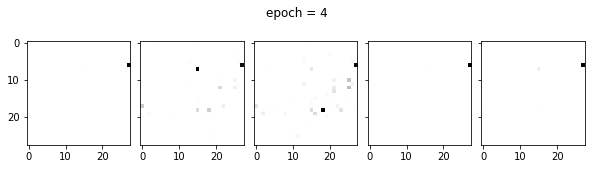

 50%|█████     | 5/10 [02:37<02:39, 31.91s/it]

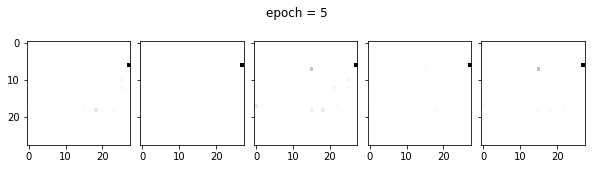

 60%|██████    | 6/10 [03:08<02:07, 31.83s/it]

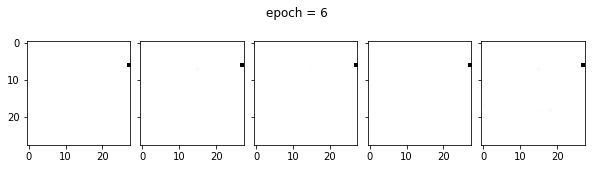

 70%|███████   | 7/10 [03:38<01:33, 31.31s/it]

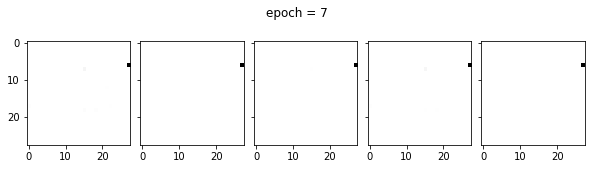

 80%|████████  | 8/10 [04:14<01:03, 31.76s/it]


KeyboardInterrupt: 

In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten

"""잠재표현 크기 설정"""
coding_size = 30

"""생성자 생성"""
generator = Sequential([
    Dense(100, activation = 'selu', input_shape = [coding_size]),
    Dense(150, activation = 'selu'),
    Dense(28 * 28, activation = 'sigmoid'),
    Reshape([28, 28])
])

"""판별자 생성"""
discriminator = Sequential([
    Flatten(input_shape = [28, 28]),
    Dense(150, activation = 'selu'),
    Dense(100, activation = 'selu'),
    Dense(  1, activation = 'sigmoid')
])

"""GAN 생성"""
gan = Sequential([generator, discriminator])

"""판별자 컴파일"""
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

"""GAN 컴파일 : 판별자의 가중치는 고정"""
discriminator.trainable = False # trainable 속성은 컴파일할 때만 영향을 끼침
gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

"""훈련 배치 생성"""
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

"""GAN 훈련 함수"""
def train_gan(gan, dataset, batch_size, coding_size, n_epochs = 10):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        for X_batch in dataset:
            # 1 단계 : 판별자 훈련
            noise = tf.random.normal(shape = [batch_size, coding_size])
            generated_images = generator(noise)
            X_fake_real = tf.concat([generated_images, X_batch], axis = 0)
            y_fake_real = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_real, y_fake_real)

            # 2 단계 : 생성자 훈련
            noise = tf.random.normal(shape = [batch_size, coding_size])
            y = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y)

        sample_images = generator.predict(noise[: 5])
        fig, subs = plt.subplots(ncols = 5, figsize = (10, 2.5), sharey = True)
        fig.subplots_adjust(wspace = .1)
        fig.suptitle(f'epoch = {epoch:.0f}')
        for i in range(5):
            subs[i].imshow(sample_images[i], cmap = 'binary')
        plt.show()

train_gan(gan, dataset, batch_size, coding_size)

# 17.9.1. GAN 훈련의 어려움

- 생성자와 판별자는 서로 경쟁하며 학습하려 함

- **내시 균형 (Nash equilibrium)** 상태에 빠지면 훈련이 되지 않음
  - 다른 플레이어가 전략을 수정하지 않을 것이므로, 어떤 플레이어도 자신의 전략을 수정하지 않는 상태
  - 한 마디로, 생성자와 판별자 모두 학습되지 않음

- **모드 붕괴 (Mode collapse)**
  - 생성자 출력의 다양성이 줄어듦
  - 판별자를 속이기 쉬운 이미지만을 생성 (예시. 다른 클래스보다 신발 이미지를 더 진짜처럼 생성하는 경우 계속해서 신발 이미지만 생성함)

- **파라미터 변동이 크고**, **불안정**함
  - 훈련이 안정적으로 시작되어도 갑자기 발산할 수 있음
  - 하이퍼파라미터가 매우 민감함

- **경험 재생 (Experience replay)**, **미니배치 판별 (Mini-batch discrimination)**과 같은 기법들을 통해 해결하고자 함